In [2]:
import pandas as pd

temperatura (e imagino que todos) datos cada 5 minutos

parametros: 
- gente que entra
- temperatura
- 

## Datos de ocupación

In [ ]:
import requests
import datetime
import time
import pandas as pd
import os

def obtener_datos_api(base_url, sensor_type_names=None, from_date=None, to_date=None, location_ids=None, tipo=None):
    """
    Extrae datos de una API en periodos de un mes y los guarda en un CSV consolidado.
    
    :param base_url: URL base de la API.
    :param sensor_type_names: Lista de nombres de sensores a consultar (opcional).
    :param from_date: Fecha de inicio en formato 'DD-MM-YYYY HH:MM' (opcional).
    :param to_date: Fecha de fin en formato 'DD-MM-YYYY HH:MM' (opcional).
    :param location_ids: Lista de IDs de ubicación (opcional).
    :param tipo: "aves" para conteo de aves, o cualquier otro valor para datos de series.
    :return: DataFrame consolidado con todos los datos.
    """
    
    def convertir_a_milisegundos(fecha_str):
        dt = datetime.datetime.strptime(fecha_str, "%d-%m-%Y %H:%M")
        return int(time.mktime(dt.timetuple()) * 1000)

    def convertir_a_fecha(epoch_ms):
        return datetime.datetime.fromtimestamp(epoch_ms / 1000).strftime("%d-%m-%Y %H:%M")

    if from_date is None:
        from_date = (datetime.datetime.now() - datetime.timedelta(days=30)).strftime("%d-%m-%Y %H:%M")
    if to_date is None:
        to_date = datetime.datetime.now().strftime("%d-%m-%Y %H:%M")

    from_epoch = convertir_a_milisegundos(from_date)
    to_epoch = convertir_a_milisegundos(to_date)

    datos_consolidados = {}
    registros = []
    periodo = 30 * 24 * 60 * 60 * 1000  # 1 mes en milisegundos

    while from_epoch < to_epoch:
        next_epoch = min(from_epoch + periodo, to_epoch)

        params = {
            "fromDate": from_epoch,
            "toDate": next_epoch
        }

        if sensor_type_names:
            params["sensorTypeNames"] = ",".join(sensor_type_names)
        if location_ids:
            params["locationIds"] = ",".join(map(str, location_ids))

        try:
            response = requests.get(base_url, params=params, verify=False)
            response.raise_for_status()
            data = response.json()
        except Exception as e:
            print(f"Error en la petición: {e}")
            from_epoch = next_epoch
            continue

        print(f"Procesando datos desde {convertir_a_fecha(from_epoch)} hasta {convertir_a_fecha(next_epoch)}")

        if tipo == "aves":
            fecha = convertir_a_fecha(from_epoch)
            if "count" in data and isinstance(data["count"], list):
                for ubicacion in data["count"]:
                    loc_id = ubicacion.get("location", "desconocido")
                    for especie, cantidad in ubicacion.get("count", []):
                        registros.append({
                            "timestamp": fecha,
                            "location": loc_id,
                            "species": especie,
                            "count": cantidad
                        })
            else:
                print("La respuesta no contiene la clave 'count' esperada para tipo='aves'.")

        else:
            if "series" in data:
                for variable, series_dict in data["series"].items():
                    for series_id, puntos in series_dict.items():
                        for timestamp, valor in puntos:
                            fecha = convertir_a_fecha(timestamp)
                            if fecha not in datos_consolidados:
                                datos_consolidados[fecha] = {}
                            datos_consolidados[fecha][variable] = valor
            else:
                print("La respuesta no contiene la clave 'series'.")

        from_epoch = next_epoch

    os.makedirs("data", exist_ok=True)

    if tipo == "aves":
        if not registros:
            print("No se obtuvieron datos de aves.")
            return None

        df_final = pd.DataFrame(registros)
        df_final = df_final.sort_values(["timestamp", "location", "species"])
        csv_filename = f"data/datos_aves_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_final.to_csv(csv_filename, index=False)

    else:
        if not datos_consolidados:
            print("No se obtuvieron datos.")
            return None

        df_final = pd.DataFrame.from_dict(datos_consolidados, orient="index")
        df_final.index.name = "timestamp"
        df_final = df_final.reset_index()
        df_final = df_final.sort_values("timestamp")
        csv_filename = f"data/datos_series_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
        df_final.to_csv(csv_filename, index=False)

    print(f"Datos guardados en {csv_filename}")
    return df_final


In [14]:

url_api = "https://platon.grc.upv.es/sensingtools-api/api/user-hard-sensors/hup4zYsBoTGoLusGWiIj/data" 
sensores = ["count_in", "count_out"]
fecha_inicio = "10-09-2024 00:01"
fecha_fin = "11-12-2024 00:01"
ubicaciones = ['hup4zYsBoTGoLusGWiIj_entrada-outdoor_38.02497_-0.65828_0']

df_final = obtener_datos_api(url_api, sensores, fecha_inicio, fecha_fin, ubicaciones)


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 10-09-2024 00:01 hasta 10-10-2024 00:01


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 10-10-2024 00:01 hasta 08-11-2024 23:01


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 08-11-2024 23:01 hasta 08-12-2024 23:01


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 08-12-2024 23:01 hasta 11-12-2024 00:01
Datos guardados en data/datos_series_20250325_094824.csv


Ahora convertimos datos a integer  y creamos nueva variable `people_inside`  que representa el número de personas dentro del parque en el momento

In [17]:
df_final = pd.read_csv("data/datos_ocupacion.csv")
df_final["count_in"] = df_final["count_in"].astype('Int64')
df_final["count_out"] = df_final["count_out"].astype('Int64')
df_final["people_inside"] = df_final["count_in"] - df_final["count_out"]
df_final

,timestamp,count_in,count_out,people_inside
0,01-10-2024 00:01,0,0,0
1,01-10-2024 00:06,0,0,0
2,01-10-2024 00:11,0,0,0
3,01-10-2024 00:16,0,0,0
4,01-10-2024 00:21,0,0,0
...,...,...,...,...
39691,31-10-2024 23:47,0,1,-1
39692,31-10-2024 23:51,0,1,-1
39693,31-10-2024 23:52,0,1,-1
39694,31-10-2024 23:56,0,1,-1


## Datos de clima

In [20]:

url_api = "https://platon.grc.upv.es/sensingtools-api/api/user-hard-sensors/5rTM-4sB-iVpGSRJcSJV/data" 
sensores = ["temperatura", "velocidadviento", "direccionviento","lluvia", "intensidadlluvia", "radiacionsolar"]
fecha_inicio = "10-09-2024 00:01"
fecha_fin = "11-12-2024 00:01"
ubicaciones = ['5rTM-4sB-iVpGSRJcSJV_La Mata - Parque Natural_38.02519_-0.65845_0']

df_meteo = obtener_datos_api(url_api, sensores, fecha_inicio, fecha_fin, ubicaciones)



C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 10-09-2024 00:01 hasta 10-10-2024 00:01


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 10-10-2024 00:01 hasta 08-11-2024 23:01


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 08-11-2024 23:01 hasta 08-12-2024 23:01
Procesando datos desde 08-12-2024 23:01 hasta 11-12-2024 00:01
Datos guardados en data/datos_series_20250325_101658.csv


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [18]:
df_meteo

,timestamp,temperatura,velocidadviento,intensidadlluvia
6040,01-10-2024 00:00,20.8,0,0.0
6041,01-10-2024 00:05,20.8,0,0.0
6042,01-10-2024 00:10,20.7,0,0.0
6043,01-10-2024 00:15,20.5,0,0.0
6044,01-10-2024 00:20,20.4,0,0.0
...,...,...,...,...
14929,31-10-2024 23:35,18.2,0,0.0
14930,31-10-2024 23:40,18.1,0,0.0
14931,31-10-2024 23:45,18.1,0,0.0
14932,31-10-2024 23:50,17.9,0,0.0


 ## Datos de aves

In [16]:
url_api = "https://platon.grc.upv.es/sensingtools-api/api/user-hard-sensors/jBAFzo8B1ljoqTiFuu2B/data/count?/" 
sensores = []
fecha_inicio = "10-09-2024 00:01"
fecha_fin = "11-12-2024 00:01"
ubicaciones = []

df_aves = obtener_datos_api(url_api, sensores, fecha_inicio, fecha_fin, ubicaciones, "aves")

C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Procesando datos desde 10-09-2024 00:01 hasta 10-10-2024 00:01
Procesando datos desde 10-10-2024 00:01 hasta 08-11-2024 23:01
Procesando datos desde 08-11-2024 23:01 hasta 08-12-2024 23:01
Procesando datos desde 08-12-2024 23:01 hasta 11-12-2024 00:01
Datos guardados en data/datos_aves_20250325_095049.csv


C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
C:\Users\hugol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'platon.grc.upv.es'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [19]:
df_aves

,timestamp,location,species,count
107,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Alectoris rufa,1
108,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Anthus pratensis,1
109,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Ardea ibis,1
110,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Carduelis carduelis,1
111,08-11-2024 23:01,jBAFzo8B1ljoqTiFuu2B_L3906629_38.02382_-0.68343_0,Columba palumbus,1
...,...,...,...,...
75,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Erithacus rubecula,1
76,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Myiopsitta monachus,1
69,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Phalacrocorax carbo,2
77,10-10-2024 00:01,jBAFzo8B1ljoqTiFuu2B_L6177434_38.02585_-0.66656_0,Streptopelia decaocto,1


# METHOD

## Data Analitics:

- Data curation
- Data description
- Data Inference


Dado que los datos de count_in son incrementales y no tenemos datos exactos de las personas que entra y salen del parque, usamos el número de personas que entran por día y haremos la predicción por días en lugar de por horas.
A continuación nos quedamos con las filas con valor máximo de count_in por cada día.

In [9]:
ocupacion = pd.read_csv("data/datos_ocupacion.csv")
ocupacion['timestamp'] = pd.to_datetime(ocupacion['timestamp'], dayfirst=True)
ocupacion['fecha'] = ocupacion['timestamp'].dt.date
df_ocupacion_dia = ocupacion.loc[ocupacion.groupby('fecha')['count_in'].idxmax()]
df_ocupacion_dia = df_ocupacion_dia[['fecha', 'count_in']]
df_ocupacion_dia




,fecha,count_in
11060,2024-09-10,98.0
12870,2024-09-11,114.0
14261,2024-09-12,133.0
15819,2024-09-13,167.0
17349,2024-09-14,199.0
...,...,...
7106,2024-12-06,151.0
8339,2024-12-07,128.0
9539,2024-12-08,163.0
10819,2024-12-09,50.0


Siguiendo la lógica anterior y para poder hacer el análisis y estudiar la correlación entre las personas en el parque y las distintas variables debemos agregarlas por días, teniendo asíu granularidad diaria en todas ellas

-  **temperatura**:  _temp_min_, _temp_max_ y _temp_promedio_
-  **velocidadviento**:  _viento_promedio_ y _viento_max_ 
- **lluvia**: _precipitacion_acumulada_ y _duracion_lluvia_min_
- **intensidadlluvia**: _intensidad_max_ e _intensidad_promedio_

Count in segmentar en lluvia y uno lluvia. Hacer test de hipotesis y ver si hay diferencias entre ellos.  Segmentar también entre semana y fin de semana.

TEMPERATURA PROMEDIO : 3 intervalos: fria ( < 15 ) moderada (15 - 27) y alta (>27) 

In [ ]:
meteo = pd.read_csv("data/datos_meteo.csv")
meteo['timestamp'] = pd.to_datetime(meteo['timestamp'], dayfirst=True)


meteo['fecha'] = meteo['timestamp'].dt.date

meteo = meteo.groupby('fecha').agg(
    temp_min=('temperatura', 'min'),
    temp_max=('temperatura', 'max'),
    temp_promedio=('temperatura', 'mean'),

    viento_max=('velocidadviento', 'max'),
    viento_promedio=('velocidadviento', 'mean'),

    precioutacion_acumulada=('lluvia', 'sum'),
    duracion_lluvia_min=('lluvia', lambda x: (x > 0).sum() * 5),  # minutos de lluvia

    # Intensidad de lluvia
    intensidad_max=('intensidadlluvia', 'max'),
    intensidad_promedio=('intensidadlluvia', 'mean')
).reset_index()

meteo = meteo.round(2)
meteo

,fecha,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,lluvia_total,duracion_lluvia_min,intensidad_max,intensidad_promedio
0,2024-09-10,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0
1,2024-09-11,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0
2,2024-09-12,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0
3,2024-09-13,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0
4,2024-09-14,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
88,2024-12-07,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0
89,2024-12-08,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0
90,2024-12-09,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0
91,2024-12-10,6.8,16.6,10.76,10,3.21,0.0,0,0.0,0.0


Juntamos los datos de ocupación y las variables climáticas en un mismo dataframe final

In [16]:
df = pd.merge(df_ocupacion_dia, meteo, on='fecha', how='left')

In [17]:
df

,fecha,count_in,temp_min,temp_max,temp_promedio,viento_max,viento_promedio,lluvia_total,duracion_lluvia_min,intensidad_max,intensidad_promedio
0,2024-09-10,98.0,20.4,28.0,24.83,13,4.53,0.0,0,0.0,0.0
1,2024-09-11,114.0,23.9,28.3,26.00,23,6.98,0.0,0,0.0,0.0
2,2024-09-12,133.0,20.4,30.2,25.60,34,7.68,0.0,0,0.0,0.0
3,2024-09-13,167.0,22.9,26.5,24.33,27,18.80,0.0,0,0.0,0.0
4,2024-09-14,199.0,20.9,25.6,23.59,21,10.65,111.2,1405,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
87,2024-12-06,151.0,12.9,25.9,19.13,18,5.29,0.0,0,0.0,0.0
88,2024-12-07,128.0,14.9,25.2,19.42,18,5.70,0.0,0,0.0,0.0
89,2024-12-08,163.0,12.2,17.5,14.81,23,8.91,0.0,0,0.0,0.0
90,2024-12-09,50.0,9.9,15.3,12.20,19,8.90,0.0,0,0.0,0.0


Vamos a estudiar la correlación entre las distintas variables y el número de personas en el parque ese día.  
Utilizaremos la Correlación de Pearson y representaremos los resultados en heatmap:  
- Valores cercanos a +1: correlación positiva fuerte
- Valores cercanos a -1: correlación negativa fuerte
- Valores cercanos a 0: sin correlación

Correlaciones con count_in:
count_in               1.000000
temp_min               0.256609
temp_promedio          0.248542
temp_max               0.158723
viento_promedio        0.054132
viento_max             0.045748
intensidad_max        -0.104990
intensidad_promedio   -0.151955
lluvia_total          -0.173954
duracion_lluvia_min   -0.225924
Name: count_in, dtype: float64


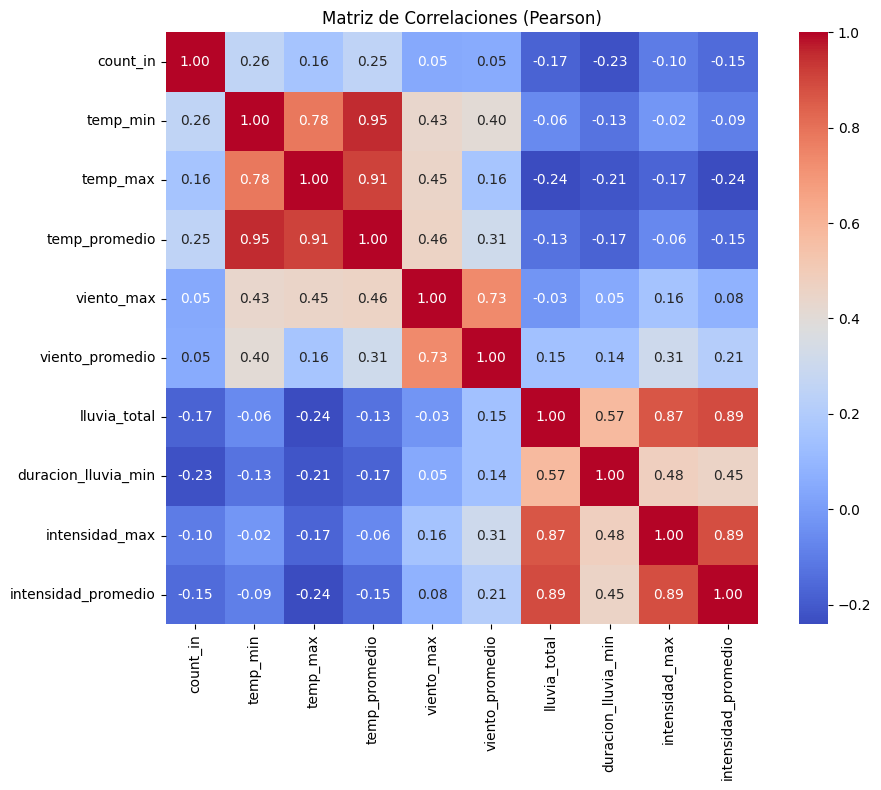

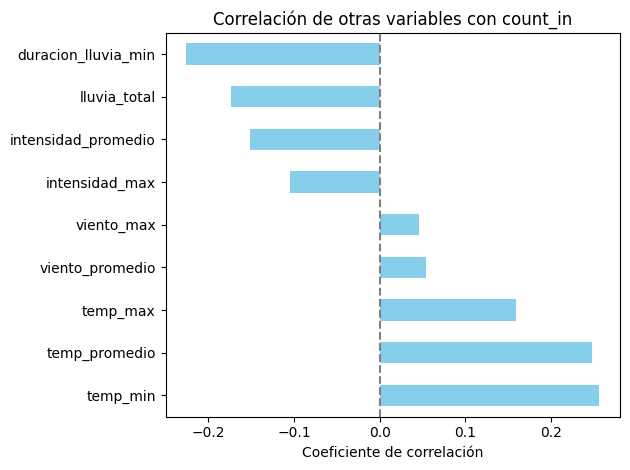

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_corr= df.select_dtypes(include='number')
correlaciones = df_corr.corr(method='pearson')

correlacion_con_count_in = correlaciones['count_in'].sort_values(ascending=False)

print("Correlaciones con count_in:")
print(correlacion_con_count_in)

plt.figure(figsize=(10, 8))
sns.heatmap(correlaciones, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Matriz de Correlaciones (Pearson)')
plt.tight_layout()
plt.show()

correlacion_con_count_in.drop('count_in').plot(kind='barh', color='skyblue')
plt.title('Correlación de otras variables con count_in')
plt.xlabel('Coeficiente de correlación')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


## Data Visualization

- time series using timeGPT / Prohet / ...
LOOK FOR THE BEST TECHNIQUE FOR OUR DATA

Hacer solo con count_in y con día de la semana etc

In [19]:
df_ts = df[['fecha', 'count_in']].copy()
df_ts.rename(columns={'fecha': 'ds', 'count_in': 'y'}, inplace=True)

df_ts['ds'] = pd.to_datetime(df_ts['ds'])

In [33]:
from nixtla import NixtlaClient
from dotenv import load_dotenv
import os

load_dotenv()

# Obtener API key
API_KEY = os.getenv("TIMEGPT_API_KEY")

# Setear clave
nixtla_client = NixtlaClient(API_KEY)

# Forecast de los próximos 14 días (por ejemplo)
forecast = nixtla_client.forecast(df=df_ts, h=14)

# Mostrar resultados
print(forecast)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Inferred freq: D
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Querying model metadata...
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


           ds     TimeGPT
0  2024-12-11   84.368240
1  2024-12-12   88.652190
2  2024-12-13   95.748730
3  2024-12-14  129.610870
4  2024-12-15  144.725520
5  2024-12-16   99.700300
6  2024-12-17   93.928070
7  2024-12-18   96.195390
8  2024-12-19   96.907510
9  2024-12-20  103.377426
10 2024-12-21  128.906590
11 2024-12-22  145.790130
12 2024-12-23  102.785550
13 2024-12-24   99.152330


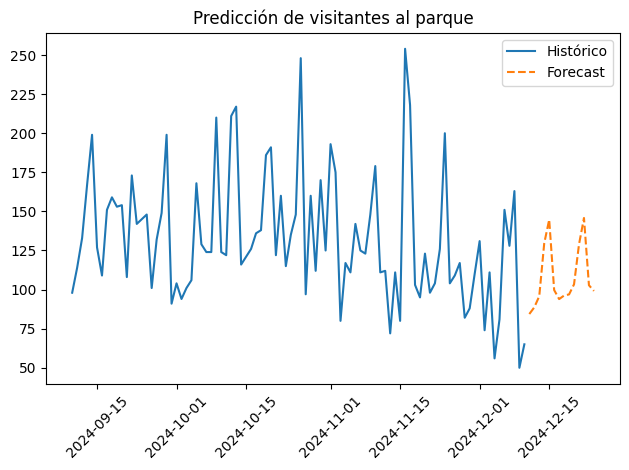

In [34]:
import matplotlib.pyplot as plt

# Graficar historial + forecast
plt.plot(df_ts['ds'], df_ts['y'], label='Histórico')
plt.plot(forecast['ds'], forecast['TimeGPT'], label='Forecast', linestyle='--')
plt.legend()
plt.title('Predicción de visitantes al parque')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


- ver si es serie temporal
- ver que modelo utilizar
- como parametizar ese modelo ( cuanto datos historicos coges apra predecir )